# Jax implementation of the Gaussian model

In [1]:
%load_ext autoreload
%autoreload 2
import site, sys, os, time
site.addsitedir('..')
from jax.config import config

#config.update("jax_enable_x64", True)

In [120]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
import jax
from jax import random

plt.rcParams["figure.figsize"]=6,6

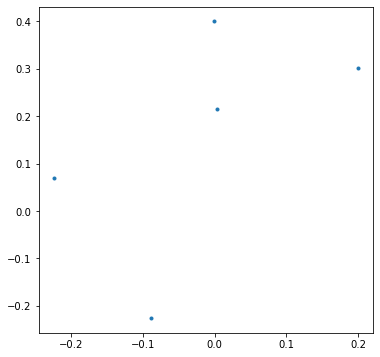

In [121]:
npt=5
pts00=jnp.array(np.random.randn(npt,2))
pts00=pts00/(jnp.max(abs(pts00))*2.5)
plt.plot(pts00[:,0], pts00[:,1],'.')

In [189]:
#### size of image. memory usage scales with N^2 of this.
boxsz=sz=128

#### precompute Fourier indices 
idx=jnp.indices((boxsz,boxsz))-boxsz//2
idx=jnp.fft.ifftshift(idx)
idx=idx[:,:,:boxsz//2+1]
idxft=(idx/sz).astype(jnp.float32)[:, None, :,:]
#rrft=jnp.sqrt(jnp.sum(idx**2, axis=0)).astype(jnp.float32)## batch, npts, x-y
rrft=jnp.sum(idx**2, axis=0).astype(jnp.float32)## batch, npts, x-y #EDIT: B
amp=jnp.exp(-rrft*.01)

In [211]:
idx.shape

(2, 128, 65)

In [212]:
rrft.shape

(128, 65)

In [213]:
amp.shape

(128, 65)

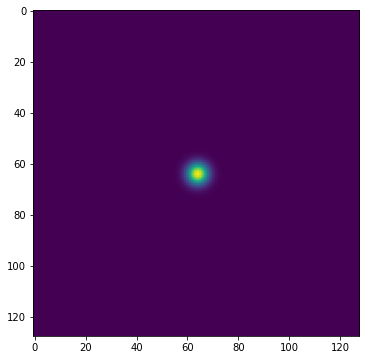

In [192]:
plt.imshow(jnp.fft.fftshift(jnp.fft.irfft2(amp)))

In [193]:
pts00[None,:,:].shape

(1, 5, 2)

In [194]:
print(idxft.shape)

(2, 1, 128, 65)


In [195]:
0.31622777**2

0.10000000251917292

In [196]:
sz

128

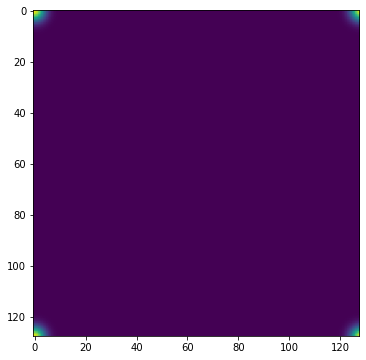

In [197]:
amp_r = jnp.fft.irfft2(amp)
amp_rx = amp_r[0]
amp_ry = amp_r[:,0]
plt.imshow(amp_r)
#plt.plot(amp_ry-amp_rx)

### Initial TensorFlow implementation, translated to JAX

pgauss_real.shape = (1, 5, 128, 65)
(1, 128, 65)


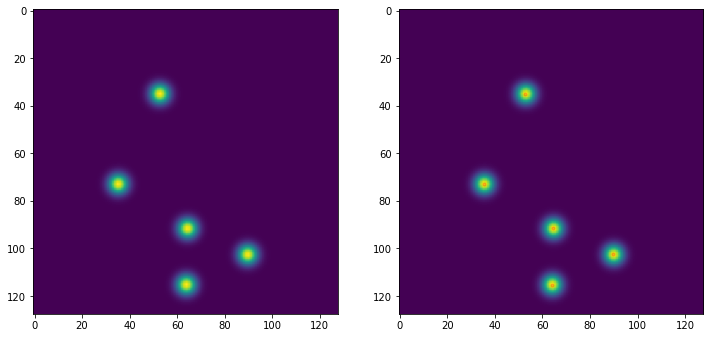

In [227]:
def pts2img(pts):
    bpos=pts*sz+sz/2
    bposft=bpos*jnp.pi*2
    bposft=bposft[:, :, :, None, None]
    
    ## this is the big 4d matrix for all Gaussian images
    ## (batchsz, # Gaussian, sz, sz//2+1)
    cpxang=idxft[0]*bposft[:,:,0] + idxft[1]*bposft[:,:,1]

    ## here we keep amplitude constand for simplification
    ## amp should be (sz, sz//2+1)
    pgauss_real=jnp.cos(cpxang)*amp
    pgauss_imag=-jnp.sin(cpxang)*amp
    
    print(f"pgauss_real.shape = {pgauss_real.shape}")
    ### EDIT B:
    # Ok so I think here there should be a different amp for each 1st dimension,
    # where amp=jnp.exp(-rrft*.sigs) and sigs has the different sigmas
    
    imgs_real=jnp.sum(pgauss_real, axis=1)
    imgs_imag=jnp.sum(pgauss_imag, axis=1)

    return (imgs_real, imgs_imag)


imgs_real, imgs_imag=pts2img(pts00[None,:,:])#.astype(jnp.float32))
print(imgs_real.shape)
#imgs_cpx=np.complex(imgs_real, imgs_imag)
imgs_cpx = imgs_real + 1j*imgs_imag
imgs_out=jnp.fft.irfft2(imgs_cpx)

img0=imgs_out[0]

plt.rcParams["figure.figsize"]=12,6
plt.subplot(1,2,1)
plt.imshow(img0)
#plt.colorbar()
p=pts00*sz+sz//2
plt.subplot(1,2,2)
plt.imshow(img0)
#plt.colorbar()
plt.plot(p[:,0], p[:,1],'.r', alpha=.2)
plt.rcParams["figure.figsize"]=6,6

### Projection in real space

In [225]:
def gen_gauss_x(centre, x, sig, sz, amp):
    return jnp.exp(-(x-centre)**2/(2*sig**2)) * max_amp

gen_gauss_x_vmap = jax.vmap(gen_gauss_x, in_axes=(0, None,0,None,None))

def pts2img_one(pts, sigs):
    p_x = gen_gauss_x_vmap(pts[:,0], idx_r, sigs, sz, max_amp)
    p_y = gen_gauss_x_vmap(pts[:,1], idx_r, sigs, sz, max_amp) 
    return jnp.matmul(p_x.transpose(), p_y).transpose()

pts2img_vmap = jax.vmap(pts2img_one, in_axes=(0,0))

Here we approximate the Gaussian in the real domain (it can be found exactly analytically).

0.0074693155166228285
0.019174762070178986


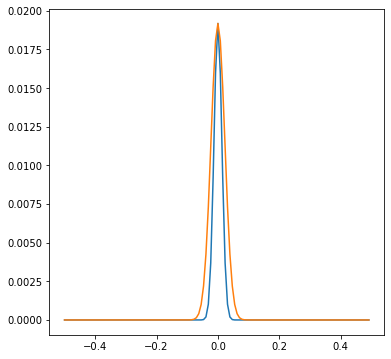

In [226]:
#print(p%pprint00.shape)
idx_r = jnp.arange(-sz/2, sz/2)/sz
#print(idx_r)
sig = 0.0129

sigs = sig + jnp.array(np.random.randn(pts00.shape[0]))*0.01
#sigs = sig * jnp.ones((pts00.shape[0],)) 

centre = 0 #pts00[4,0] #0
max_amp = jnp.max(amp_rx)
gauss_x = gen_gauss_x(idx_r, centre, sig, sz, max_amp)
plt.plot(idx_r,gauss_x)
plt.plot(idx_r, jnp.fft.fftshift(amp_rx))
#plt.plot(jnp.abs(jnp.fft.fftshift(amp_rx)-gauss_x)    )
print(jnp.max(jnp.abs(jnp.fft.fftshift(amp_rx)-gauss_x)))
print(jnp.max(gauss_x))

Generate the image, adjust the scaling so it is the same as in the previous approach, then compare the images.

(128, 128)


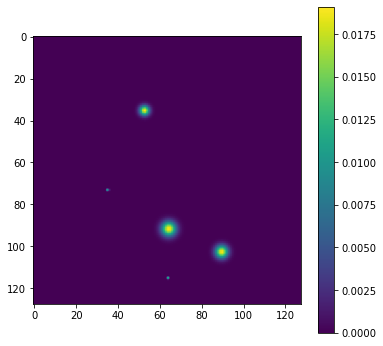

In [216]:
img1 = pts2img_one(pts00, sigs)
img1 = img1/jnp.max(img1)*jnp.max(img0)
print(img1.shape)
plt.imshow(img1);plt.colorbar()

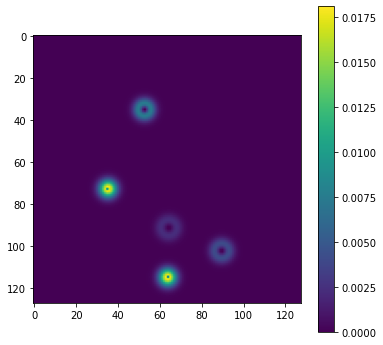

In [217]:
plt.imshow(img0-img1); plt.colorbar()

### Projection in Fourier space, memory-friendly

This implementation replicates the result of the TensorFlow implementation exactly (in single precision)

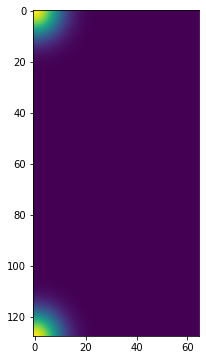

In [218]:
plt.imshow(amp)

In [204]:
amp.shape

(128, 65)

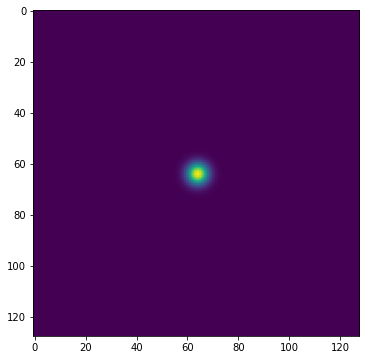

In [205]:
amp_r = jnp.fft.fftshift(jnp.fft.irfft2(amp))
plt.imshow(amp_r)

In [206]:
amp_r

DeviceArray([[ 2.23977364e-11,  1.24731336e-11, -1.55531629e-11, ...,
              -5.68797509e-11, -1.55531976e-11,  1.24731059e-11],
             [ 2.21369992e-10,  2.15287066e-10,  1.95090000e-10, ...,
               1.50655488e-10,  1.86929972e-10,  2.11565460e-10],
             [ 2.38555259e-10,  2.41273668e-10,  2.28627436e-10, ...,
               1.57953067e-10,  1.91807098e-10,  2.20713559e-10],
             ...,
             [ 1.51997248e-10,  1.56173033e-10,  1.50497989e-10, ...,
               1.04019786e-10,  1.22971883e-10,  1.40002662e-10],
             [-1.19101895e-10, -1.50689808e-10, -1.76139228e-10, ...,
              -6.66084549e-11, -7.47572143e-11, -9.20144794e-11],
             [ 3.30918348e-10,  3.34087313e-10,  3.19110738e-10, ...,
               2.33480041e-10,  2.73353729e-10,  3.09015868e-10]],            dtype=float32)

In [234]:
def mult_gauss_coords(centre, coords):
    return centre*coords

mult_gauss_coords_vmap = jax.vmap(mult_gauss_coords, in_axes=(0,None))

def pts2img2_one(pts, idxft):
    bpos=pts*sz+sz/2
    bposft=bpos*jnp.pi*2
    
    cpxang_x = mult_gauss_coords_vmap(bposft[:,0], idxft[0,0,:])   # 0 0 :
    cpxang_y = mult_gauss_coords_vmap(bposft[:,1], idxft[1,:,0])   # 1 : 0

    pgauss_x = jnp.exp(-1j*cpxang_x)
    pgauss_y = jnp.exp(-1j*cpxang_y)
    
    print(f"pgauss_x.shape = {pgauss_x.shape}")
    print(f"pgauss_y.shape = {pgauss_y.shape}")
  
    pgauss = jnp.matmul(pgauss_x.transpose(), pgauss_y).transpose() * amp
    # EDIT B: compared to the tensorflow implementation, how do we use K different amp's here?
    
    print(f"pgauss.shape = {pgauss.shape}")
    print(f"amp.shape = {amp.shape}")

    
    return pgauss

pgauss_x.shape = (5, 65)
pgauss_y.shape = (5, 128)
pgauss.shape = (128, 65)
amp.shape = (128, 65)
5.0
17.718902354214627


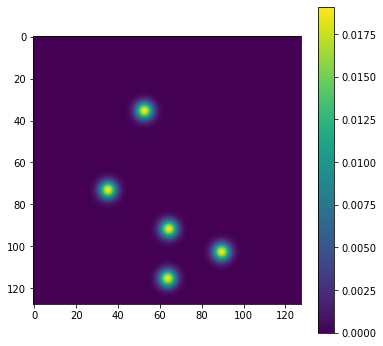

In [235]:
img_cpx2 = pts2img2_one(pts00, idxft[:,0,:,:])
print(jnp.max(jnp.real(img_cpx2)))

img2=jnp.fft.irfft2(img_cpx2)

print(jnp.max(jnp.real(img_cpx2)))

#plt.subplot(1,2,1)
plt.imshow(img2)
plt.colorbar()
#p=pts00*sz+sz//2
#plt.subplot(1,2,2)
#plt.imshow(img)
#plt.plot(p[:,0], p[:,1],'.r', alpha=.2)

Compare the two images

5.564329325559567e-16
0.01910734777163247


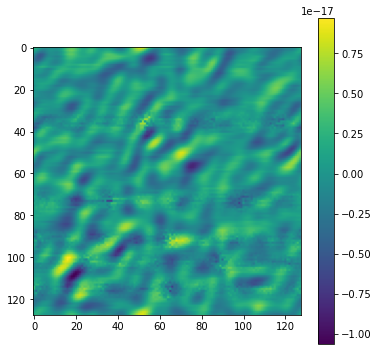

In [209]:
print(jnp.max(jnp.abs(img0-img2)/jnp.max(img0)))
print(jnp.max(img2))
plt.imshow(img0-img2); plt.colorbar()

### Loss functions

A basic squared L2 norm loss function, one for the TensorFlow approach and one for the last approach.

In [18]:
def loss_func(pts, img_f):
    imgs_real, imgs_imag=pts2img(pts)
    err_real = imgs_real - jnp.real(img_f)
    err_imag = imgs_imag - jnp.imag(img_f)
    return jnp.sum(err_real**2 + err_imag**2)

grad_loss = jax.grad(loss_func)

In [19]:
def loss_func_one(pts, img_f):
    proj_f = pts2img2_one(pts,idxft[:,0,:,:])
    err = proj_f - img_f
    return jnp.real(jnp.sum(jnp.conj(err)*err))

grad_loss_one = jax.grad(loss_func_one)

loss_func_vmap = jax.vmap(loss_func_one, in_axes = (None,0))

def loss_func_sum(pts, imgs_f):
    return jnp.mean(loss_func_vmap(pts, imgs_f))

def grad_loss_func_sum(pts, imgs_f):
    return jax.grad(loss_func_sum)(pts, imgs_f)

zero_img = jnp.zeros([sz, int(sz/2)+1])

In [20]:
t0 = time.time()
loss1 = loss_func(pts00[None,:,:], zero_img)
gp1 = grad_loss(pts00[None,:,:], zero_img)
print(time.time()-t0)

2.6777162551879883


In [21]:
t0 = time.time()
loss2 = loss_func_one(pts00, zero_img )
gp2 = grad_loss_one(pts00, zero_img)
print(time.time()-t0)

3.0769920349121094


The two approaches agree:

In [22]:
print((loss1-loss2)/jnp.max(jnp.abs(gp1)))
print(jnp.max(jnp.abs(gp1[0]-gp2))/jnp.max(jnp.abs(gp1)))

0.0
7.581762468202697e-16


In [23]:
loss1

DeviceArray(4207722.73313794, dtype=float64)

In [24]:
loss2

DeviceArray(4207722.73313794, dtype=float64)

### Generate a batch of images to test the performance

(1000, 128, 65)


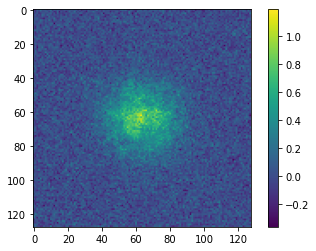

In [25]:
#### make some particle images for training later
##   they should stay in CPU as well
nptcl=1000
ptcls=0.1*np.random.randn(nptcl, sz,sz)+np.array(img2)
plt.imshow(ptcls[13]); plt.colorbar()
ptcls_f=np.fft.rfft2(ptcls)
#ptcls_real=jnp.real(ptcls_cpx).astype(jnp.float64)
#ptcls_imag=jnp.imag(ptcls_cpx).astype(jnp.float64)
print(ptcls_f.shape)

In [26]:
type(ptcls_f)

numpy.ndarray

In [27]:
print(jnp.max(img2))
print(jnp.max(ptcls[10]))

0.9697417338620369
1.1331919640914168


In [28]:
t0 = time.time()
loss2 = loss_func_one(pts00, ptcls_f[10])
gp2 = grad_loss_one(pts00, ptcls_f[10])
print(time.time()-t0)
print(gp2.shape)

0.2235274314880371
(1000, 2)


Apply the loss and the gradient functions to the batch of 1000 images.

In [29]:
t0 = time.time()
loss_sum = loss_func_sum(pts00, ptcls_f)
print(time.time() - t0)
print(loss_sum)

0.8687114715576172
1363562.0523936246


In [30]:
t0 = time.time()
grad_loss = grad_loss_func_sum(pts00, ptcls_f)
print(time.time() - t0)
print(grad_loss.shape)

1.116408348083496
(1000, 2)


Jax allocates all the available memory at the beginning, so the following does not tell us much (other than the total available memory, 8GB in this case)

In [31]:
os.system("nvidia-smi ");

Tue Jun 21 16:05:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.39.01    Driver Version: 510.39.01    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     On   | 00000000:1A:00.0 Off |                  Off |
| 33%   35C    P2    62W / 260W |    378MiB / 49152MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Gradient descent on the Gaussian locations

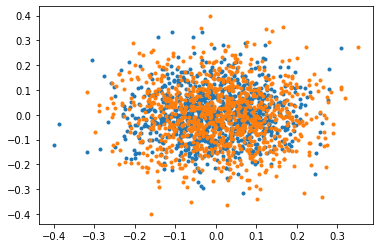

In [32]:
# Sample the initial points in the same way as the correct ones.

p0 = jnp.array(np.random.randn(npt,2))
p0 = p0/(jnp.max(abs(p0))*2.5)

plt.plot(pts00[:,0],pts00[:,1], '.')
plt.plot(p0[:,0],p0[:,1], '.')

In [33]:
N_iter = 1000
alpha = 1e-7

p = p0
for i in range(N_iter):
    gl = grad_loss_func_sum(p, ptcls_f)
    p = p - alpha * gl
    if jnp.mod(i,50)==0:
        print(i, jnp.linalg.norm(gl,2))


0 760260.3703473232
50 42002.540973723095
100 21626.03028695043
150 13738.115915259104
200 11011.330022693113
250 8300.708655111257
300 8695.939240761734
350 5296.14947328065
400 3804.6314608067073
450 4268.525443628099
500 5904.13077638138
550 3921.053847004603
600 3766.0663709356227
650 4832.691329183141
700 3896.0888208611705
750 3179.2728513947727
800 3363.771115557031
850 4155.194104645928
900 3701.8198157322336
950 4059.644275674214


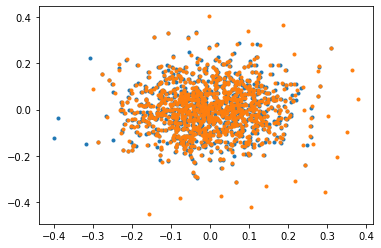

In [34]:
# Estimated Gaussian locations

plt.plot(pts00[:,0],pts00[:,1], '.')
plt.plot(p[:,0],p[:,1], '.')

In [35]:
ptcls_f.shape

(1000, 128, 65)